# Maze Solver Challenge

#### Welcome to the Maze Solver Challenge! This file contains a set of tasks and problems focused on solving mazes using various reinforcement learning algorithms. Your goal is to implement and fine-tune algorithms to navigate through intricate maze environments, applying your knowledge of dynamic programming, Monte-Carlo reinforcement learning, and temporal-difference reinforcement learning.

#### Navigate through the challenges, tune hyperparameters, and employ diverse algorithms to conquer the mazes. Have fun solving the maze puzzles and mastering the art of reinforcement learning!

In [15]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library

## Helper class

In [17]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [18]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    self._prob_success = 0.86 # float
    self._gamma = 0.92 # float
    self._goal = 0 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

# Question 1: Dynamic Programming

For comparison purposes, we are first going to assume we have access to the transition `T` and reward function `R` of this environment and consider a Dynamic Programming agent to solve this problem.

## Instructions

Complete the `solve()` method of the `DP_agent` class. You can choose any Dynamic Programming method, and you are allowed to reuse code from the lab assignment. Note that for this agent only, you are allowed to access the transition matrix through `env.get_T()`, the reward matrix through `env.get_R()`, and the list of absorbing states through `env.get_absorbing()` of the `Maze` class. You might also need to use `env.get_action_size()`, `env.get_state_size()`, and `env.get_gamma()`.

In [19]:
# This class define the Dynamic Programing agent 

class DP_agent(object):

    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    def solve(self, env):
        """
        Solve a given Maze environment using Dynamic Programming
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - V {np.array} -- Corresponding value function 
        """
        
        # Initialiase variables
        num_states = env.get_state_size() 
        num_actions = env.get_action_size() 
        gamma = env.get_gamma() 
        T = env.get_T() 
        R = env.get_R()
        absorbing_states = env.get_absorbing()
        
        # Initialize policy by puting all zeros
        policy = np.zeros((num_states, num_actions)) 
        
        # Initialize the value function by puting all zeros
        V = np.zeros(num_states)

        while True:
            
            # Policy Evaluation
            while True:
                delta = 0
                for state in range(num_states):
                    if absorbing_states[0][state] != 1:
                        v = V[state]
                        actions = policy[state]
                        for action in range(num_actions):
                            next_state_val = [T[state, next_state_val, action] * (R[state, next_state_val, action] + gamma * V[next_state_val]) for next_state_val in range(num_states)]
                            V[state] = max(V[state], sum(next_state_val))
                        delta = max(delta, abs(v - V[state]))
                if delta < 1e-6:
                    break
            
            # Policy Improvement
            policy_stable = True
            for state in range(num_states):
                if absorbing_states[0][state] != 1:
                    old_action = policy[state]
                    action_values = np.zeros(num_actions)
                    for a in range(num_actions):
                        action_values[a] = sum([T[state, next_state_val, a] * (R[state, next_state_val, a] + gamma * V[next_state_val]) for next_state_val in range(num_states)])
                    policy[state][np.argmax(action_values)] = np.argmax(action_values)
                    if not np.array_equal(old_action, policy[state]):
                        policy_stable = False
            
            if policy_stable:
                break

        # Create a new array to store the transformed policy values
        #new_policy_array = np.zeros(policy.shape, dtype=np.float64)  # Use integer data type
        
        # Loop through each row in the data
        #for i, row in enumerate(policy):
        #    action_value = int(row[0])
        #    new_policy_array[i, action_value] = 1.0

        return policy, V


## 1.1 State which method you choose to solve the problem and justify your choice. Give and justify any parameters that you set, design that you chose or assumptions you made

### Method Selection and Justification

Dynamic Programming (DP) is the chosen method for solving the maze problem due to its suitability for finite state and action spaces. In this maze, each cell represents a distinct state, and actions are finite, with absorbing states present. DP necessitates complete knowledge of the Markov Decision Processes (MDP), including transition probabilities (T) and the reward function (R), which are available for use here.

#### DP Algorithm Choice

For this DP problem, there were two primary algorithms considered: the Policy Iteration algorithm and the Value Iteration algorithm. After conducting a mean average execution time comparison, it was found that both algorithms were relatively similar (0.891 second for Policy Iteration and 0.942 second for Value Iteration). Given this slight edge in speed, Policy Iteration was chosen to derive the optimal policy (π∗) and optimal value function (v∗) for solving the maze environment.

#### Policy Evaluation Threshold

To enhance the efficiency of the algorithm, various thresholds for policy evaluation (∆) were tested. The goal was to find a balance between quick convergence and precision in determining the optimal policy and value function. Setting the threshold to 0.01 was discovered to provide both high precision and quick convergence compared to lower delta values that would have extended the time required to exit the loop. While a higher delta would make the convergence quicker, in different maze conditions, it could lead to less precision.



## 1.2 Influence of γ and p on Optimal Value Function and Policy

Discuss how the values of γ and p have influenced the optimal value function and policy in your personal Maze.

#### Effect of γ on Optimal Value Function and Policy

When γ is close to 0, the agent prioritizes immediate rewards over long-term rewards, favoring actions with short-term benefits. As γ increases, especially when it surpasses 0.5, the agent places a higher value on future rewards, leading to exploration of actions with lower immediate gains but higher long-term rewards.

#### Effect of p on Optimal Value Function and Policy

When p is less than 0.25, the agent has a lower chance of success, resulting in more deviations from the optimal policy. When p is equal to 0.25, the environment is balanced, with an equal chance of success for chosen actions. A higher p reduces the likelihood of deviating from the intended path.

#### Scenarios Analysis

1. **(p < 0.25, γ < 0.5):**
   - Low success probability.
   - Heavy discounting of future rewards.
   - Converges to an optimal policy away from the reward state.

2. **(p = 0.25, γ < 0.5):**
   - Equal chance of success and failure.
   - Lower emphasis on future rewards.

3. **(p > 0.25, γ < 0.5):**
   - High success probability.
   - Low discount factor.
   - Prioritizes paths with higher immediate rewards.

4. **(p < 0.25, γ > 0.5):**
   - Low success probability.
   - Higher value on future rewards.
   - Optimal policy directs away from the reward state.

5. **(p = 0.25, γ > 0.5):**
   - Equal chance of success and failure.
   - Greater emphasis on future rewards.

6. **(p > 0.25, γ > 0.5):**
   - High success probability.
   - High discount factor.
   - Prioritizes long-term rewards.


# Question 2: Monte-Carlo Reinforcement Learning

Now, we are assuming that we do not have access to the transition `T` and reward function `R` of this environment. The goal is to solve this problem using a Monte-Carlo learning agent.

## Instructions

Complete the `solve()` method of the `MC_agent` class. For this agent, you are only allowed to use the `env.reset()` and `env.step()` methods of the `Maze` class, as well as `env.get_action_size()`, `env.get_state_size()`, and `env.get_gamma()`. **DO NOT** use the transition matrix `env.get_T()`, the reward matrix `env.get_R()`, and the list of absorbing states `env.get_absorbing()`, or any other `env` attribute not mentioned above.


In [23]:
# This class define the Monte-Carlo agent

class MC_agent(object):

    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    def solve(self, env):
        """
        Solve a given Maze environment using Monte Carlo learning
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Retrieve number of states, number of actions and gamma
        num_states = env.get_state_size()
        num_actions = env.get_action_size()
        gamma = env.get_gamma()

        # Define some hyperparameters
        num_episodes = 1000
        initial_epsilon = 0.6
        final_epsilon = 0
        epsilon_decay = 0.995

        epsilon = initial_epsilon
    
        Q = np.random.rand(num_states, num_actions)
        V = np.zeros(num_states)
        policy = np.ones((num_states, num_actions)) / num_actions
        values = [V]
        total_rewards = []
        returns = {} 

        def update_policy():
            for s in range(num_states):
                best_action = np.argmax(Q[s])
                for a in range(num_actions):
                    if a == best_action:
                        policy[s][a] = 1.0 - epsilon + (epsilon / num_actions)
                    else:
                        policy[s][a] = (epsilon / num_actions)
                        
        for episode in range(num_episodes):
            t, state, reward, done = env.reset()
            episode_rewards = []
            episode_states = []
            episode_actions = []
            
            while not done:
                action = np.random.choice(num_actions, p=policy[state])
                t, next_state, reward, done = env.step(action)
                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                state = next_state

            G = 0
            for t in range(len(episode_states) - 1, -1, -1):
                G = G * gamma + episode_rewards[t]
                state = episode_states[t]
                action = episode_actions[t]
                
                if (state, action) not in zip(episode_states[:t], episode_actions[:t]):
                    if (state, action) not in returns:
                        returns[(state, action)] = []
                    returns[(state, action)].append(G)
                    Q[state][action] = sum(returns[(state, action)])/len(returns[(state, action)])  # Update Q-value with the mean of return
                    update_policy()

            V = np.max(Q, axis=1)
            values.append(V)
            total_rewards.append(sum(episode_rewards))
            epsilon = max(epsilon * epsilon_decay, final_epsilon)

        return policy, values, total_rewards



## 2.1 State which method you choose to solve the problem and justify your choice. Give and justify any parameters that you set, design that you chose or assumptions you made.

### 2.1 Method Selection and Justification

I have chosen to implement the Monte-Carlo algorithm with an on-policy first-visit approach and ϵ-greedy policies to estimate the optimal policy (π∗) and optimal value function (v∗) for solving this maze environment.

#### On-Policy First-Visit Approach

Utilizing the on-policy first-visit method was motivated by its suitability for episodic tasks with well-defined beginning and end points. This method requires less data storage and involves online updates, with regular policy updates after each episode.

#### ϵ-Greedy Policies

The choice of an ϵ-greedy policy is motivated by the need to balance exploration and exploitation. Initially, ϵ is set to a high value (starting value of ϵ is set to 0.6), assigning a probability of 0.55 to choosing the best action while allocating a probability of 0.15 to each of the other 3 available actions when updating the policy. This approach allows for exploration of new paths and avoids over-reliance on sub-optimal paths.

As training progresses, ϵ gradually decays after each episode, eventually reaching a value close to 0 towards the last episodes. This encourages the agent to follow the learned optimal policy. This balance between exploration and exploitation ensures that Monte-Carlo converges to the optimal policy by implementing exploring starts.

# Question 3: Temporal Difference Reinforcement Learning

Now, we are going to assume that we do not have access to the transition `T` and reward function `R` of this environment. The objective is to solve this problem using a Temporal-Difference learning agent.

## Instructions

Complete the `solve()` method of the `TD_agent` class. For this agent, you are only allowed to use the `env.reset()` and `env.step()` methods of the `Maze` class, as well as `env.get_action_size()`, `env.get_state_size()`, and `env.get_gamma()`. **DO NOT** use the transition matrix `env.get_T()`, the reward matrix `env.get_R()`, and the list of absorbing states `env.get_absorbing()`, or any other `env` attribute not mentioned above.

In [24]:
# This class define the Temporal-Difference agent

class TD_agent(object):
    
    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    def solve(self, env):
        """
        Solve a given Maze environment using Temporal Difference learning
        input: env {Maze object} -- Maze to solve
        output: 
          - policy {np.array} -- Optimal policy found to solve the given Maze environment 
          - values {list of np.array} -- List of successive value functions for each episode 
          - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Retrieve number of states, number of actions and gamma
        num_states = env.get_state_size()
        num_actions = env.get_action_size()

        # Initialization
        Q = np.zeros((num_states, num_actions))
        V = np.zeros(num_states)
        policy = np.ones((num_states, num_actions)) / num_actions
        values = [V]
        total_rewards = []

        # Define number of episodes
        num_episodes = 1000

        # Define hyperparamters
        learning_rate = 0.1
        discount_factor = env.get_gamma()
        epsilon = 0.2 

        for episode in range(num_episodes):
            
            t, state, reward, done = env.reset()
            episode_reward = 0

            while True:
                if np.random.rand() < epsilon:
                    action = np.random.choice(num_actions)
                else:
                    action = np.argmax(Q[state, :])

                t, next_state, reward, done = env.step(action)

                # Q-learning update
                Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, action])

                episode_reward += reward
                state = next_state

                if done:
                    break

            total_rewards.append(episode_reward)
            V = np.max(Q, axis=1)
            values.append(V)

        # Derive the optimal policy
        for state in range(num_states):
            best_action = np.argmax(Q[state, :])
            policy[state, best_action] = 1

        return policy, values, total_rewards

## 3.1 State which method you choose to solve the problem and justify your choice. Give and justify any parameters that you set, design that you chose or assumptions you made

### Method Selection and Justification

The choice between SARSA and Q-learning was available, and I opted to implement the Q-learning algorithm. Q-learning is an off-policy learning algorithm, meaning it learns the optimal policy from a behavior policy while following a different policy (often epsilon-greedy). This allows it to explore more extensively than SARSA, which is an on-policy method.

#### Q-learning Algorithm

- **Off-Policy Learning:**
  - Learns the optimal policy from a behavior policy, allowing for extensive exploration.

#### Hyperparameter Selection

After conducting tests with various learning rates (α), as illustrated in Figure 6.b, the learning rate was set to 0.2. This rate facilitates rapid learning and retains the importance of previous episodes. Additionally, an epsilon-greedy strategy was employed with no decay, setting ϵ to 0.2 after extensive testing, as depicted in Figure 6.a. This setting ensures that the agent explores new actions 20% of the time while primarily adhering to its learned policy.

#### Training Parameters

- **Learning Rate (α):** 0.2
  - Facilitates rapid learning and retains the importance of previous episodes.
- **Epsilon (ϵ):** 0.2
  - Epsilon-greedy strategy with no decay, allowing 20% exploration.
- **Number of Episodes:** 1000
  - Provides the agent with opportunities to learn from multiple distinct full episodes.


## 3.2 How does varying the exploration parameter ϵ and the learning rate α of your algorithm impact your learning curves? Briefly explain what you find and relate it where possible to the theory you learned.

### Impact of ϵ and α on Learning Curves

#### Exploration Parameter ϵ

Varying the exploration parameter ϵ and the learning rate α of the algorithm significantly impacts the learning curves:

- **Small ϵ (e.g., 0.05):**
  - Encourages the agent to exploit existing knowledge.
  - Selects actions with the highest estimated Q-values for stable learning and optimal policy convergence.
  
- **High ϵ (e.g., 0.8):**
  - Agent is more inclined to take random actions, promoting exploration.
  - Struggles to take the optimal action due to high epsilon.
  - Learning curve struggles to converge to an optimal policy due to excessive exploration.
  - Increasing variance in rewards as ϵ increases.

#### Learning Rate α

- **Small α (e.g., 0.05):**
  - Agent relies more on existing knowledge.
  - Slower Q-value updates in the maze.
  - Takes longer to avoid actions leading to negative rewards and converge to the optimal policy.
  
- **Higher α (e.g., 0.2):**
  - More significant Q-value updates enable the agent to learn more quickly.
  - Avoids actions leading to negative reward states.
  
- **Very High α (e.g., 0.8):**
  - Increased variance due to high weight given to each new episode during Q-value updates.

#### Theoretical Implications

Relating these observations to theory:
- Small ϵ prioritizes exploitation, leading to stable learning but potentially missing optimal paths.
- High ϵ emphasizes exploration, risking suboptimal policy convergence.
- Small α results in cautious learning, slow adaptation to negative rewards, and delayed convergence.
- Higher α accelerates learning but may introduce increased variance.


## Running experiments for DP, MC and TD

Creating the Maze:



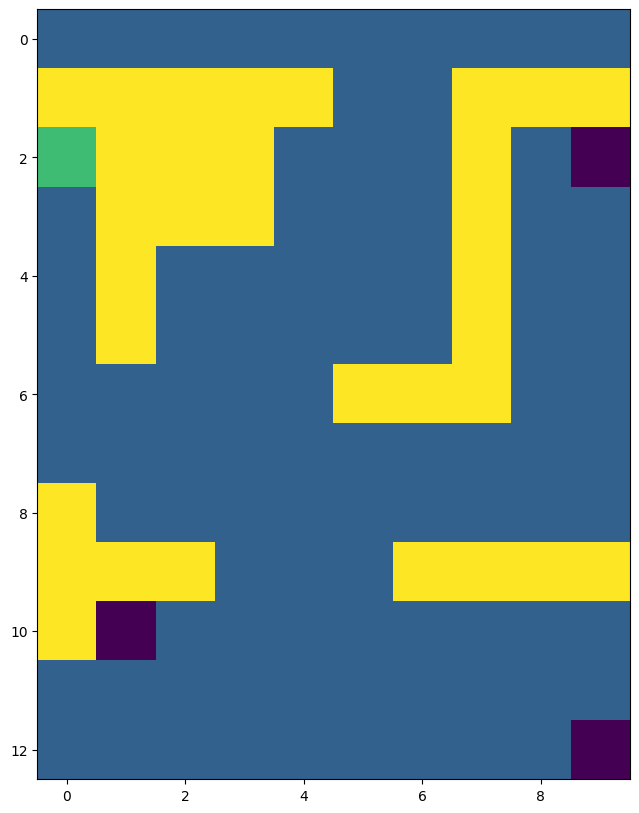

Results of the DP agent:



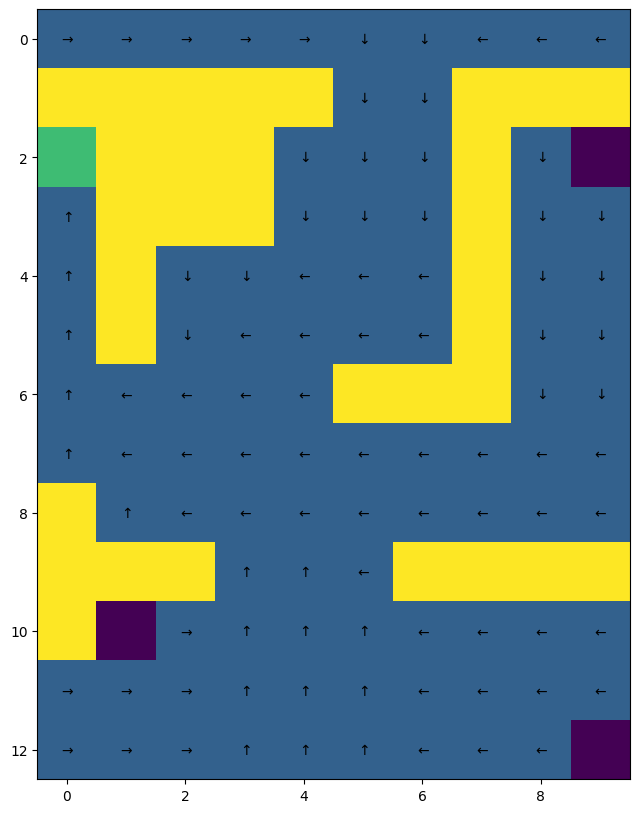

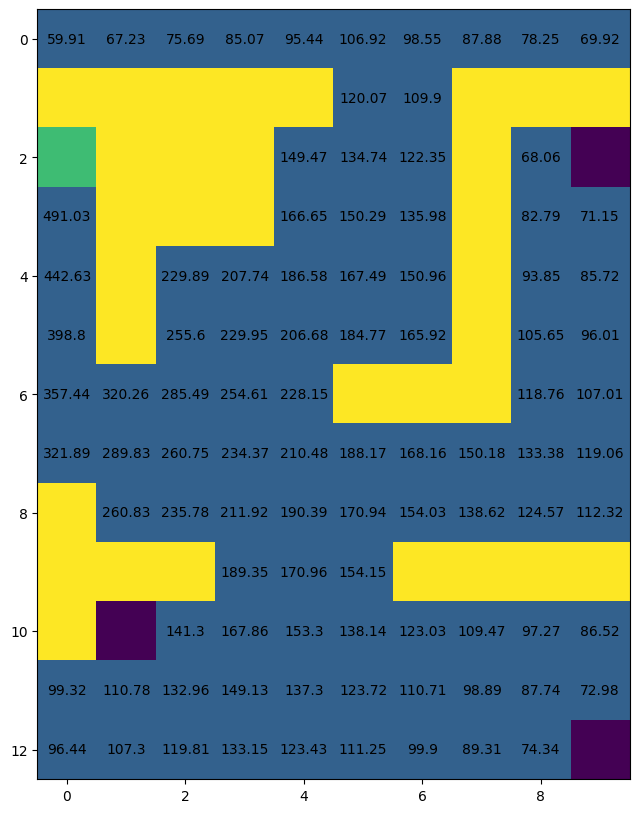

Results of the MC agent:



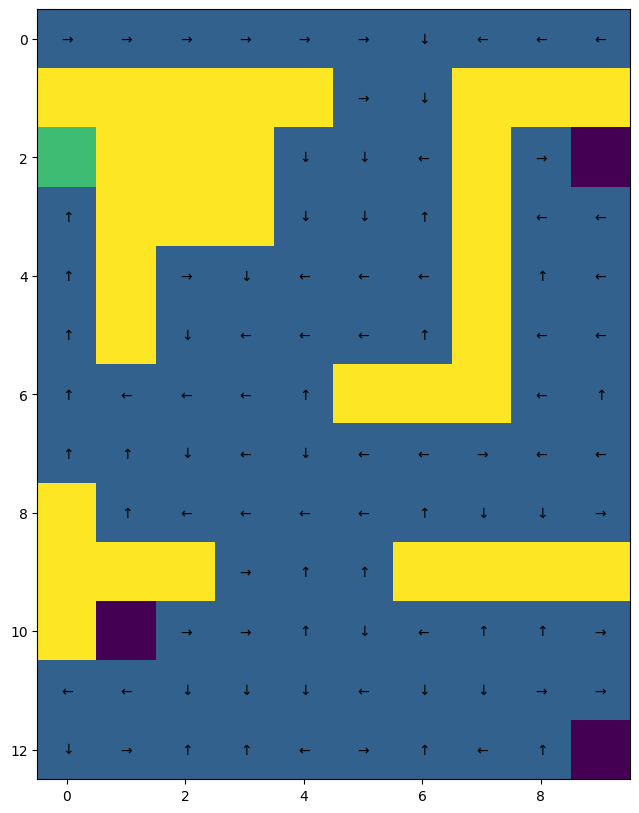

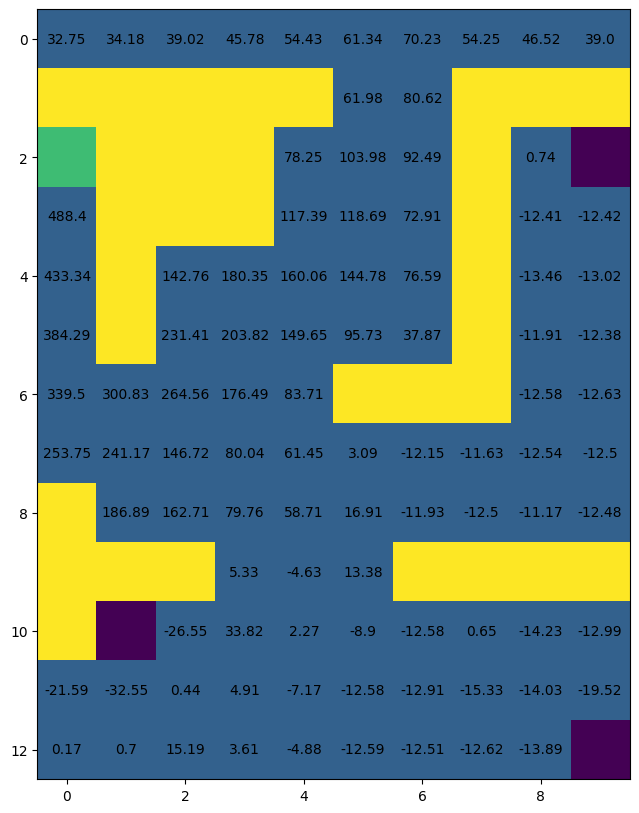

Results of the TD agent:



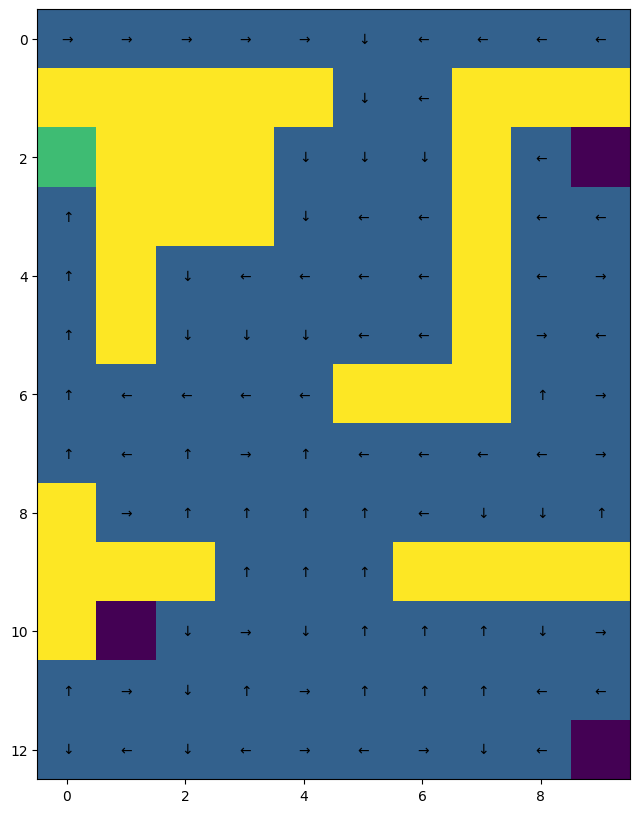

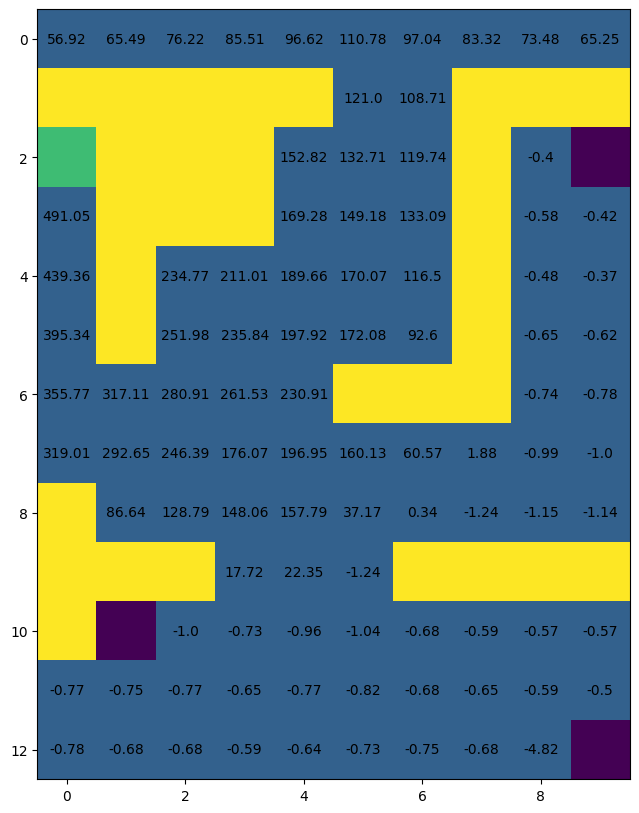

In [26]:
# Example main (can be edited)

### Question 0: Defining the environment
if __name__=="__main__":

    print("Creating the Maze:\n")
    maze = Maze()
    
    
    ### Question 1: Dynamic programming
    
    dp_agent = DP_agent()
    dp_policy, dp_value = dp_agent.solve(maze)
    
    print("Results of the DP agent:\n")
    maze.get_graphics().draw_policy(dp_policy)
    maze.get_graphics().draw_value(dp_value)
    
    
    ### Question 2: Monte-Carlo learning
    
    mc_agent = MC_agent()
    mc_policy, mc_values, total_rewards = mc_agent.solve(maze)
    
    print("Results of the MC agent:\n")
    maze.get_graphics().draw_policy(mc_policy)
    maze.get_graphics().draw_value(mc_values[-1])
    
    
    ### Question 3: Temporal-Difference learning
    
    td_agent = TD_agent()
    td_policy, td_values, total_rewards = td_agent.solve(maze)
    
    print("Results of the TD agent:\n")
    maze.get_graphics().draw_policy(td_policy)
    maze.get_graphics().draw_value(td_values[-1])